
> Dataset loaded: data\project_data.csv
> SMOTE applied. Training size: 7786
> Training initial Random Forest model...
> 5-Fold CV Accuracy: 88.16%
> Test Set Accuracy: 83.36%

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       975
           1       0.71      0.76      0.73       425

    accuracy                           0.83      1400
   macro avg       0.80      0.81      0.81      1400
weighted avg       0.84      0.83      0.84      1400



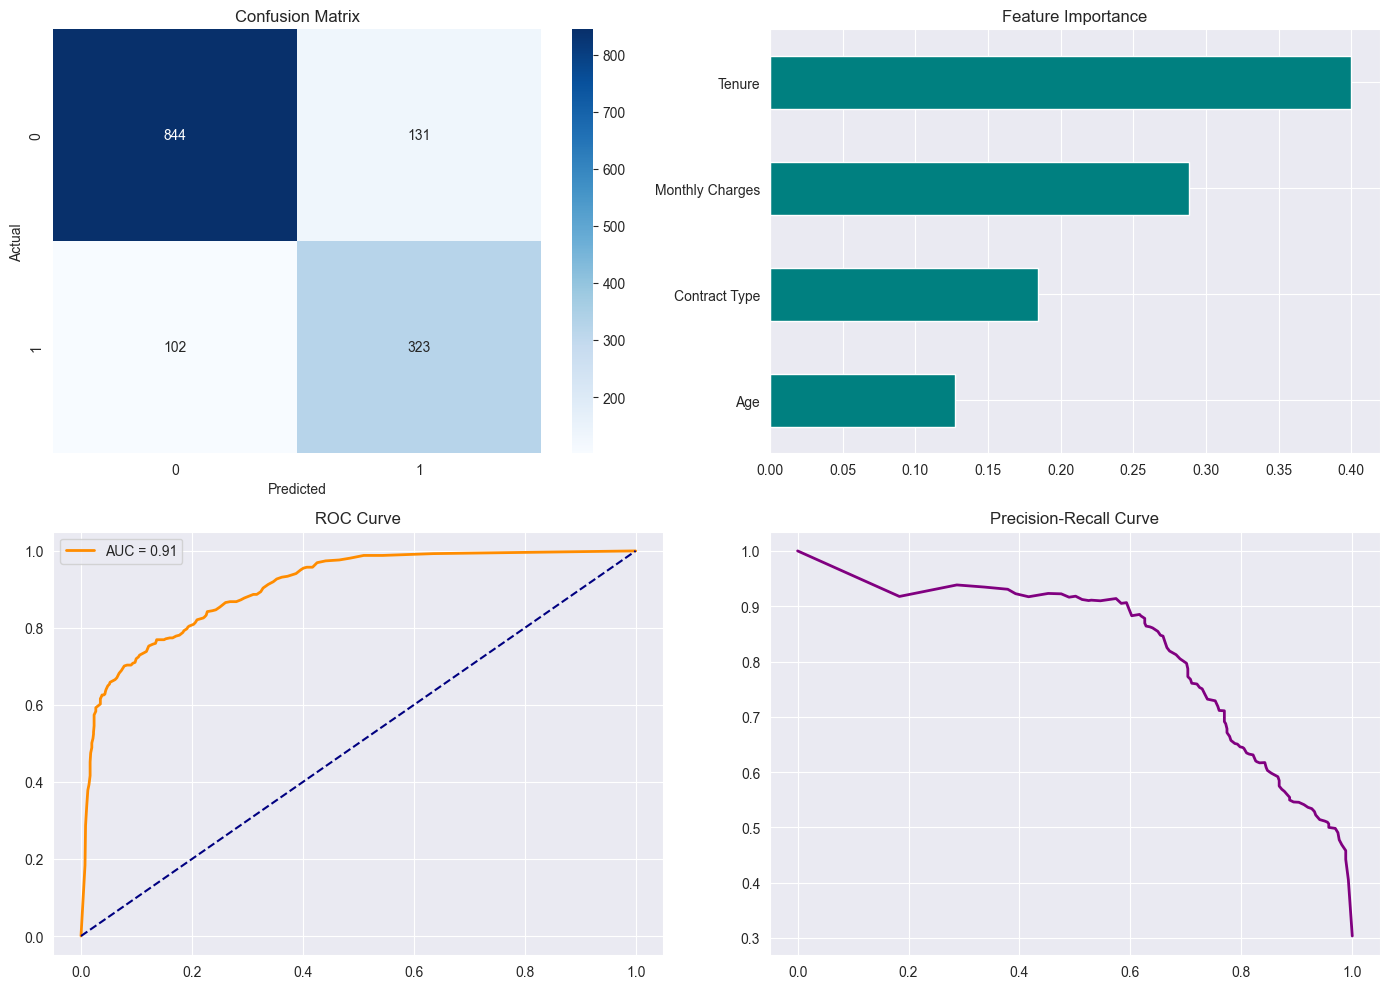

> Generating SHAP summary...


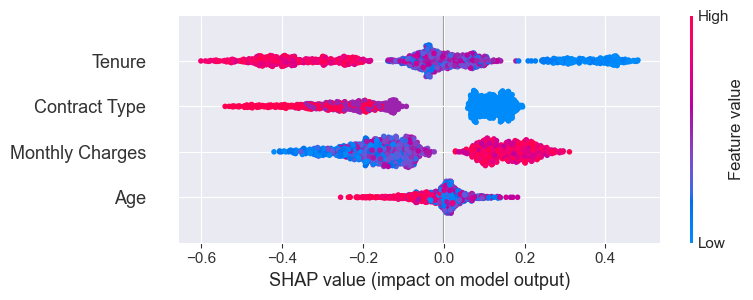


--- Business Action Plan ---
> Action plan saved to: demos\Risk_Customer_Action_Plan.csv


,Monthly Charges,Tenure,Recommended_Action
2024,61.19,31,Call from VIP Agent
263,74.38,10,Send Standard Retention Email
6362,44.42,13,Send Standard Retention Email
6406,48.55,6,Send Standard Retention Email
4279,99.07,15,Offer 15% Discount



--- Live Prediction Demo ---
Customer (Age 25, $95, 2mo) -> Prediction: CHURN (100.0%)
Customer (Age 55, $40, 60mo) -> Prediction: STAY (0.0%)

--- Model Benchmark ---
Random Forest: 83.36%
Logistic Reg.: 79.93%
Decision Tree: 79.14%
Grad. Boosting: 83.36%


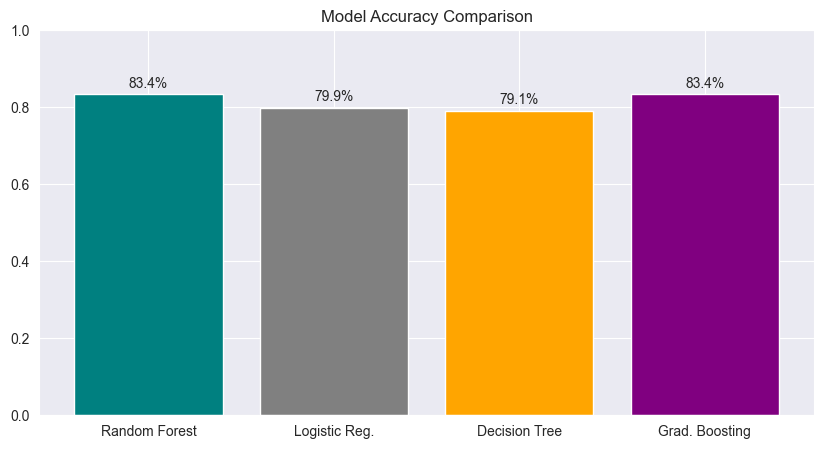


--- Hyperparameter Tuning ---
> Optimizing Random Forest with GridSearchCV (this may take a moment)...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
> Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
> Optimized Accuracy: 83.36%

--- Optimal Threshold Tuning ---
> Best Threshold for F1-Score: 0.63
> Max F1-Score: 0.75

---: Financial Impact Analysis ---
Avg Monthly Revenue: $70.24
Potential Loss (Risk): $31888.58
Retention Cost: $4540.00
------------------------------
ESTIMATED NET SAVINGS: $11404.29

--- Finalizing & Saving ---
> Ensemble (Voting) Accuracy: 83.29%
> Best model and scaler saved to 'models/'


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_recall_curve, average_precision_score, f1_score
from imblearn.over_sampling import SMOTE
import joblib
import os
import warnings

# Suppress warnings for a cleaner output
warnings.filterwarnings('ignore')

# Check for SHAP
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("[Note] SHAP not found. Install it for better explanations: pip install shap")

%matplotlib inline

# --- Setup Directories ---
current_path = os.getcwd()
if current_path.endswith("notebooks"):
    os.chdir("..")

DATA_DIR = 'data'
MODELS_DIR = 'models'
IMAGES_DIR = 'images'
DEMOS_DIR = 'demos'
REPORTS_DIR = 'reports'

for d in [MODELS_DIR, IMAGES_DIR, DEMOS_DIR, REPORTS_DIR]:
    if not os.path.exists(d):
        os.makedirs(d)

#LOAD DATA
file_path = os.path.join(DATA_DIR, 'project_data.csv')
try:
    df = pd.read_csv(file_path)
    print(f"\n> Dataset loaded: {file_path}")
except FileNotFoundError:
    print(f"[Error] File not found: {file_path}")
    raise SystemExit

#PREPROCESSING
if 'Customer ID' in df.columns:
    df = df.drop('Customer ID', axis=1)

le = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = le.fit_transform(df[col])

# Save correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.savefig(os.path.join(IMAGES_DIR, 'correlation_matrix.png'))
plt.close()

#SPLITTING & SMOTE
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test_original = X_test.copy()

try:
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    print(f"> SMOTE applied. Training size: {len(X_train)}")
except Exception as e:
    print(f"> SMOTE failed, continuing without it. ({e})")

#SCALING (Keep Columns)
scaler = StandardScaler()
X_train_scaled_arr = scaler.fit_transform(X_train)
X_test_scaled_arr = scaler.transform(X_test)

# Convert back to DF to keep feature names
X_train_scaled = pd.DataFrame(X_train_scaled_arr, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled_arr, columns=X.columns)

# BASE MODEL TRAINING
print("> Training initial Random Forest model...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5)
print(f"> 5-Fold CV Accuracy: {cv_scores.mean()*100:.2f}%")

#EVALUATION
y_pred = rf_model.predict(X_test_scaled)
y_prob = rf_model.predict_proba(X_test_scaled)[:, 1]

print(f"> Test Set Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

# Visualizations
plt.figure(figsize=(14, 10))

# Confusion Matrix
plt.subplot(2, 2, 1)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Feature Importance
plt.subplot(2, 2, 2)
pd.Series(rf_model.feature_importances_, index=X.columns).sort_values().plot(kind='barh', color='teal')
plt.title('Feature Importance')

# ROC Curve
plt.subplot(2, 2, 3)
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc(fpr, tpr):.2f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('ROC Curve')
plt.legend()

# PR Curve
plt.subplot(2, 2, 4)
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.plot(recall, precision, color='purple', lw=2, label=f'AP = {average_precision_score(y_test, y_prob):.2f}')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, 'model_performance.png'))
plt.show()

# SHAP Analysis
if SHAP_AVAILABLE:
    try:
        print("> Generating SHAP summary...")
        explainer = shap.TreeExplainer(rf_model)
        shap_values = explainer.shap_values(X_test_scaled, check_additivity=False)

        vals = shap_values[1] if isinstance(shap_values, list) else shap_values
        if len(np.array(vals).shape) == 3: vals = vals[:, :, 1]

        plt.figure()
        shap.summary_plot(vals, X_test_scaled, feature_names=X.columns, show=False)
        plt.savefig(os.path.join(IMAGES_DIR, 'shap_summary.png'))
        plt.show()
    except Exception as e:
        print(f"[Warning] SHAP issue: {e}")

#BUSINESS ACTIONS
print("\n--- Business Action Plan ---")

action_plan = X_test_original.copy()
action_plan['Predicted_Churn'] = y_pred
risk_customers = action_plan[action_plan['Predicted_Churn'] == 1].copy()

def get_action(row):
    try:
        mc = row.get('Monthly Charges', 0)
        tenure = row.get('Tenure', 0)
        if mc > 80: return "Offer 15% Discount"
        elif tenure > 24: return "Call from VIP Agent"
        elif tenure < 6: return "Send Satisfaction Survey"
        else: return "Send Standard Retention Email"
    except:
        return "General Retention"

if not risk_customers.empty:
    risk_customers['Recommended_Action'] = risk_customers.apply(get_action, axis=1)
    save_path = os.path.join(DEMOS_DIR, 'Risk_Customer_Action_Plan.csv')
    risk_customers.to_csv(save_path, index=False)
    print(f"> Action plan saved to: {save_path}")

    cols = [c for c in ['Monthly Charges', 'Tenure', 'Recommended_Action'] if c in risk_customers.columns]
    display(risk_customers[cols].head())
else:
    print("> No churn predicted.")

#LIVE DEMO
print("\n--- Live Prediction Demo ---")

def predict_customer(age, contract_type, monthly_charges, tenure):
    try:
        input_data = pd.DataFrame(np.zeros((1, len(X.columns))), columns=X.columns)

        if 'Age' in input_data: input_data['Age'] = age
        if 'Monthly Charges' in input_data: input_data['Monthly Charges'] = monthly_charges
        if 'Tenure' in input_data: input_data['Tenure'] = tenure

        if 'Contract' in input_data: input_data['Contract'] = contract_type
        elif 'Contract Type' in input_data: input_data['Contract Type'] = contract_type

        input_scaled = pd.DataFrame(scaler.transform(input_data), columns=X.columns)
        pred = rf_model.predict(input_scaled)[0]
        prob = rf_model.predict_proba(input_scaled)[0][1]

        status = "CHURN" if pred == 1 else "STAY"
        print(f"Customer (Age {age}, ${monthly_charges}, {tenure}mo) -> Prediction: {status} ({prob*100:.1f}%)")
    except Exception as e:
        print(f"Demo Error: {e}")

predict_customer(25, 0, 95, 2)
predict_customer(55, 2, 40, 60)

#MODEL BENCHMARKING
print("\n--- Model Benchmark ---")
model_results = {'Random Forest': accuracy_score(y_test, y_pred)}

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)
model_results['Logistic Reg.'] = accuracy_score(y_test, lr.predict(X_test_scaled))

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_scaled, y_train)
model_results['Decision Tree'] = accuracy_score(y_test, dt.predict(X_test_scaled))

gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_scaled, y_train)
model_results['Grad. Boosting'] = accuracy_score(y_test, gb.predict(X_test_scaled))

for name, score in model_results.items():
    print(f"{name}: {score*100:.2f}%")

# Benchmark Plot
plt.figure(figsize=(10, 5))
bars = plt.bar(model_results.keys(), model_results.values(), color=['teal', 'gray', 'orange', 'purple'])
plt.ylim(0, 1.0)
plt.title('Model Accuracy Comparison')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval*100:.1f}%', ha='center', va='bottom')
plt.savefig(os.path.join(IMAGES_DIR, 'model_comparison.png'))
plt.show()

#HYPERPARAMETER TUNING (Optimizing RF)
print("\n--- Hyperparameter Tuning ---")
print("> Optimizing Random Forest with GridSearchCV (this may take a moment)...")

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=1)

grid_search.fit(X_train_scaled, y_train)

best_rf_model = grid_search.best_estimator_
print(f"> Best Parameters: {grid_search.best_params_}")
print(f"> Optimized Accuracy: {best_rf_model.score(X_test_scaled, y_test)*100:.2f}%")

# THRESHOLD TUNING
print("\n--- Optimal Threshold Tuning ---")
# Default threshold is 0.5. Let's find the one that maximizes F1-Score
thresholds = np.arange(0, 1, 0.01)
f1_scores = [f1_score(y_test, (y_prob >= t).astype(int)) for t in thresholds]
best_thresh = thresholds[np.argmax(f1_scores)]

print(f"> Best Threshold for F1-Score: {best_thresh:.2f}")
print(f"> Max F1-Score: {max(f1_scores):.2f}")

# FINANCIAL IMPACT ANALYSIS
print("\n---: Financial Impact Analysis ---")
# Assumptions for the business case
avg_revenue = df['Monthly Charges'].mean()
marketing_cost = 10  # Cost to keep a customer (e.g. discount)
success_rate = 0.5   # % of customers who stay after receiving offer

n_churn_predicted = sum(y_pred)
potential_loss = n_churn_predicted * avg_revenue
saved_revenue = n_churn_predicted * success_rate * avg_revenue
program_cost = n_churn_predicted * marketing_cost
net_savings = saved_revenue - program_cost

print(f"Avg Monthly Revenue: ${avg_revenue:.2f}")
print(f"Potential Loss (Risk): ${potential_loss:.2f}")
print(f"Retention Cost: ${program_cost:.2f}")
print("-" * 30)
print(f"ESTIMATED NET SAVINGS: ${net_savings:.2f}")

# VOTING & DEPLOYMENT
print("\n--- Finalizing & Saving ---")

# We use the Optimized RF model here
voting_clf = VotingClassifier(estimators=[
    ('rf', best_rf_model),
    ('gb', gb),
    ('lr', lr)], voting='soft')

voting_clf.fit(X_train_scaled, y_train)
acc = voting_clf.score(X_test_scaled, y_test)
print(f"> Ensemble (Voting) Accuracy: {acc*100:.2f}%")

joblib.dump(voting_clf, os.path.join(MODELS_DIR, 'churn_prediction_model.pkl'))
joblib.dump(scaler, os.path.join(MODELS_DIR, 'scaler.pkl'))
print(f"> Best model and scaler saved to '{MODELS_DIR}/'")